# Checking the data
Natalia Vélez, February 2022

In [1]:
%matplotlib inline
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
from utils import gsearch, read_json, str_extract, int_extract

sns.set_context('talk')
sns.set_style('white')

## Data wrangling

Load data from main trials

In [2]:
data_files = gsearch('inputs/student_data*.json')
data_files.sort()
print('Found %i batches of data' % len(data_files))
print(*data_files, sep='\n')

Found 5 batches of data
inputs/student_data_2022-02-02-1303.json
inputs/student_data_2022-02-15-1328.json
inputs/student_data_2022-02-15-2034.json
inputs/student_data_2022-02-16-1639.json
inputs/student_data_2022-02-25-1021.json


In [3]:
student_list = []
time_list = []
processed_workers = []

for f in data_files:
    batch = str_extract('[0-9]{4}-[0-9]{2}-[0-9]{2}-[0-9]{4}', f)
    print('Processing batch: %s' % batch)
    student_json = read_json(f)
    
    print('%i participants found' % len(student_json))
    print(student_json[0].keys())
    
    for stud in student_json:
        worker_id = stud['worker']
        
        if worker_id not in processed_workers:
            order = stud['cond']
            data = pd.DataFrame(stud['data'])
            data['worker'] = worker_id
            data['order'] = order
            data['batch'] = batch
            time = data.iloc[-1]['time_elapsed']

            student_list.append(data)
            time_list.append((batch, worker_id, time))
            processed_workers.append(worker_id)

all_data = pd.concat(student_list).drop(columns=['trial_index', 'internal_node_id'])

student_df = all_data[all_data.trial_type == 'student-bet']
student_df = student_df.dropna(how='all', axis=1).drop(columns=['trial_type'])
student_df.to_csv('outputs/student_behavior.csv', index=False)

print(student_df.shape)
student_df.head()

Processing batch: 2022-02-02-1303
20 participants found
dict_keys(['worker', 'assignment', 'hit', 'version', 'cond', 'problem_order', 'data', 'timestamp'])
Processing batch: 2022-02-15-1328
20 participants found
dict_keys(['worker', 'assignment', 'hit', 'version', 'cond', 'problem_order', 'data', 'timestamp'])
Processing batch: 2022-02-15-2034
80 participants found
dict_keys(['worker', 'assignment', 'hit', 'version', 'cond', 'problem_order', 'data', 'timestamp'])
Processing batch: 2022-02-16-1639
110 participants found
dict_keys(['worker', 'assignment', 'hit', 'version', 'cond', 'problem_order', 'data', 'timestamp'])
Processing batch: 2022-02-25-1021
120 participants found
dict_keys(['worker', 'assignment', 'hit', 'version', 'cond', 'problem_order', 'data', 'timestamp'])
(16150, 10)


,time_elapsed,teacher,problem,num_trial,num_hint,bets,bonus,worker,order,batch
22,181304,sub-04,34,0.0,0.0,"[0, 35, 41, 48]",0.013777,ARI1EMAHUA9PO,0,2022-02-02-1303
23,192911,sub-04,34,0.0,1.0,"[0, 50, 49, 0]",0.020623,ARI1EMAHUA9PO,0,2022-02-02-1303
24,203582,sub-04,34,0.0,2.0,"[0, 0, 100, 0]",0.041667,ARI1EMAHUA9PO,0,2022-02-02-1303
26,223655,sub-27,15,1.0,0.0,"[0, 52, 50, 48]",0.014444,ARI1EMAHUA9PO,0,2022-02-02-1303
27,232054,sub-27,15,1.0,1.0,"[0, 52, 50, 0]",0.021242,ARI1EMAHUA9PO,0,2022-02-02-1303


Sanity check: Do all students belong to exactly one batch?

In [4]:
batches_per_student = student_df.groupby(['worker']).agg({'batch': 'nunique'})
print(np.all(batches_per_student.batch == 1))

True


Sanity check: How many students per batch?

In [5]:
student_df.groupby('batch').agg({'worker': 'nunique'}).reset_index().worker

0    20
1    20
2    60
3    30
4    10
Name: worker, dtype: int64

## Calculate bonuses

Calculate total time:

In [6]:
time_elapsed = pd.DataFrame(time_list, columns=['batch', 'worker', 'time_elapsed'])
time_elapsed['t_minutes'] = time_elapsed['time_elapsed']/1000/60
time_elapsed['t_minutes'].agg(['min', 'max', 'median'])

min       10.513533
max       96.065400
median    24.790617
Name: t_minutes, dtype: float64

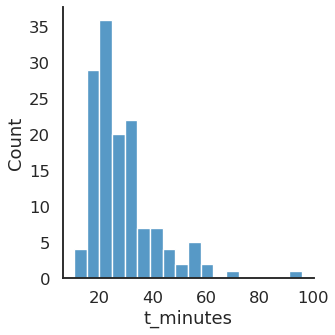

In [7]:
sns.displot(time_elapsed.t_minutes)

Calculate bonuses:

In [8]:
latest_batch = student_df.batch.unique()[-1]# process only for latest batch
bonuses = (
    student_df
    [student_df.batch == latest_batch]
    .groupby('worker')
    .agg({'bonus': 'sum'})
    .reset_index()
)
bonuses['bonus'] = np.round(bonuses.bonus, 2)
print(bonuses.shape)
bonuses.head()

(10, 2)


,worker,bonus
0,A11Q8U6QTT8KGF,2.59
1,A1CFMY4CEYOM8Y,2.42
2,A1OYQLIDML0DPW,1.36
3,A1UTN872NUHB39,2.78
4,A2G43KS55YGYQE,2.34


Calculate pay per hour:

In [9]:
pay_per_hour = time_elapsed.merge(bonuses)
pay_per_hour['total_pay'] = pay_per_hour['bonus']+2
pay_per_hour['hourly_rate'] = pay_per_hour['total_pay']/(pay_per_hour['t_minutes']/60)
pay_stats = pay_per_hour.hourly_rate.agg(['min', 'max', 'median'])
pay_stats

min        4.444384
max       17.428079
median    10.642642
Name: hourly_rate, dtype: float64

Adjust bonus payments to increase hourly rate:

In [10]:
bonus_file = 'outputs/student_bonuses_%s.csv' % latest_batch
print('Saving bonuses to: %s' % bonus_file)
bonuses.to_csv(bonus_file, header=False, index=False)

Saving bonuses to: outputs/student_bonuses_2022-02-25-1021.csv


## Check assignments

Load teacher data, for comparison:

In [11]:
# Exclude wiggly participants
excluded = np.loadtxt('../1_preprocessing/outputs/excluded_participants.txt', dtype=str)
excluded = [int_extract('(?<=sub-)[0-9]+', s) for s in excluded]

# Clean up behavioral data
teacher_df = pd.read_csv('../2_behavioral/outputs/teaching_behavior.csv')
teacher_df = teacher_df[~teacher_df.subject.isin(excluded)]
teacher_df = teacher_df.dropna(subset=['example'], axis=0)

# Find teacher-problem pairings that were included in student task
n_hints = teacher_df.groupby(['subject', 'problem'])['example'].agg('count').reset_index()
valid_hints = (
    n_hints
    [n_hints.example > 1]
    [['subject', 'problem']]
    .rename(columns={'subject': 'teacher'})
)
valid_hints

,teacher,problem
0,1,0
1,1,1
2,1,2
3,1,3
4,1,4
...,...,...
1114,30,35
1115,30,36
1116,30,37
1117,30,38


Was each participant assigned to unique order?

In [12]:
orders = student_df.order.unique()
orders.sort()
orders

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139])

In [13]:
assignments = student_df.groupby('order').agg({'worker': 'nunique'}).reset_index()
np.all(assignments.worker == 1)

True

In [14]:
np.setdiff1d(np.arange(139), orders)

array([], dtype=int64)

How many ratings has each teacher received so far?

In [15]:
# Count # of students who have seen each teacher-problem pairing
n_ratings = (
    student_df
    .groupby(['teacher', 'problem'])
    .agg({'worker': 'nunique'})
    .reset_index()
    .rename(columns={'worker': 'students'})
)
n_ratings['teacher'] = n_ratings.teacher.apply(lambda s: int_extract('(?<=sub-)[0-9]+', s))
n_ratings['problem'] = n_ratings.problem.astype(int)

# Expand valid hints into a teacher x problem matrix
hint_mtx = valid_hints.merge(n_ratings, how='left').fillna(0)
hint_mtx = hint_mtx.pivot(index='problem', columns='teacher')

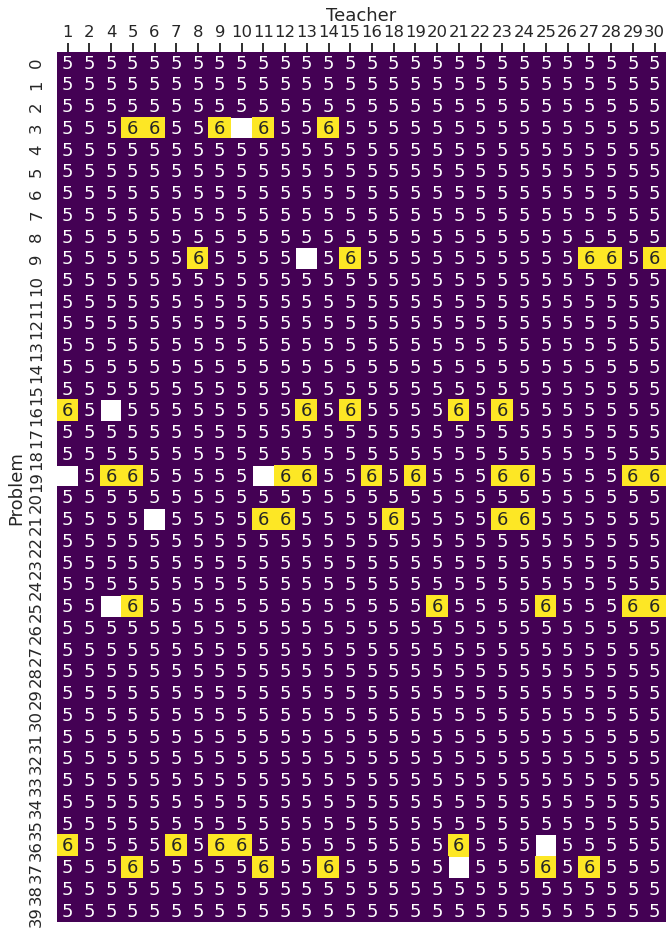

In [16]:
# Plot distribution
fig,ax=plt.subplots(figsize=(16,16))
sns.heatmap(hint_mtx, square=True, cbar=False, annot=True, cmap='viridis', ax=ax)
xlabels = [item.get_text() for item in ax.get_xticklabels()]
xlabels = [int_extract('(?<=students-)[0-9]+', x) for x in xlabels]
ax.set(xlabel='Teacher', ylabel='Problem', xticklabels=xlabels)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 

How many unique teachers did each student see? 

min     23.000000
max     28.000000
mean    27.771429
Name: teacher, dtype: float64


[Text(0.5, 15.439999999999998, '# Unique teachers per student')]

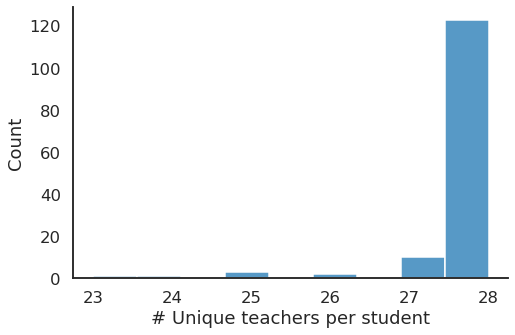

In [22]:
unique_teachers = student_df.groupby('worker').agg({'teacher': 'nunique'}).reset_index()
g = sns.displot(unique_teachers.teacher, aspect=1.5)
print(unique_teachers['teacher'].agg(['min', 'max', 'mean']))

g.axes[0,0].set(xlabel='# Unique teachers per student')

Check: How many problem-teacher combinations did we drop from the study?

In [18]:
dropped_hints = valid_hints.groupby('teacher').agg({'problem': 'nunique'}).reset_index()
dropped_hints['dropped'] = 40 - dropped_hints.problem
dropped_hints.groupby('dropped').agg({'teacher': 'nunique'})

,teacher
dropped,
0,20
1,7
2,1


## Check survey responses

Task descriptions:

In [19]:
task_descriptions = (
    all_data
    [all_data.trial_type == 'survey-text']
    [['worker', 'response']]
)
task_descriptions['response'] = task_descriptions.response.apply(lambda r: r['Q0'])

for _, row in task_descriptions.iterrows():
    print('%s: "%s"\n' % (row.worker, row.response))

ARI1EMAHUA9PO: "making bets on which of 4 choices was described via block placement in hints"

A1VFOKKVJ7B9D6: "I was given hints to solve a puzzle and bet on the options that were given below."

A2I4PRZ9IZMKON: "I had to try to guess which pattern was correct. I was given hints one square at a time from former participants."

A34EHWOYRBL6OZ: "I had to place bets on the most likely answer based on hints I was given by a person in an earlier version of the HIT"

A3OZ8KF0HWSVWK: "Making bets on squares with filled in clues "

A2QTL039A5VV3I: "Trying to use patterns from previous contestants to see which answer they got. Getting the correct answer and betting the most led to the most bonus"

A35S5YV2XL971J: "It was really good to improve the concentration nd thinking power. It was a great hit."

A3E8SXH0BAYG85: "I was to make bets on which grid was correct. I was given hits to help with this process. There were 4 total grids on each round."

A2A1FS0KVLJ9ZT: "I had to play a game based on 

Worker feedback:

In [20]:
posttest = (
    all_data
    [all_data.trial_type == 'post-survey']
    .dropna(axis=1, how='all')
)
posttest.head()

,trial_type,time_elapsed,language,enjoyment,assess,age,gender_cat,gender_text,education,comments,worker,order,batch
178,post-survey,1163485,english,average,y,44,m,,college,,ARI1EMAHUA9PO,0,2022-02-02-1303
175,post-survey,1299828,English,better,y,46,f,,some-college,,A1VFOKKVJ7B9D6,3,2022-02-02-1303
196,post-survey,1110116,English,average,y,31,f,,college,I enjoyed it.,A2I4PRZ9IZMKON,11,2022-02-02-1303
181,post-survey,1487965,English,better,y,34,f,,high,none,A34EHWOYRBL6OZ,6,2022-02-02-1303
180,post-survey,1623271,English,average,y,56,m,,some-college,,A3OZ8KF0HWSVWK,2,2022-02-02-1303
